# Welcome to the interactive Galaxy IPython Notebook.

You can access your data via the dataset number. Using a Python kernel, you can access dataset number 42 with ``handle = open(get(42), 'r')``.
To save data, write your data to a file, and then call ``put('filename.txt')``. The dataset will then be available in your galaxy history.
<br>When using a non-Python kernel, ``get`` and ``put`` are available as command-line tools, which can be accessed using system calls in R, Julia, and Ruby. For example, to read dataset number 42 into R, you can write ```handle <- file(system('get -i 42', intern = TRUE))```.
To save data in R, write the data to a file and then call ``system('put -p filename.txt')``.
Notebooks can be saved to Galaxy by clicking the large green button at the top right of the IPython interface.<br>
More help and informations can be found on the project [website](https://github.com/bgruening/docker-jupyter-notebook).

# Imports

In [1]:
from bioblend.galaxy import GalaxyInstance
import pandas as pd
from io import StringIO
import os
import requests
import pip
import matplotlib.pyplot as plt
pip.main(["install", "openpyxl"])
import numpy as np
import seaborn as sns

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: openpyxl in /home/engynasr/anaconda3/lib/python3.11/site-packages (3.0.10)

Requirement already satisfied: et_xmlfile in /home/engynasr/anaconda3/lib/python3.11/site-packages (from openpyxl) (1.1.0)

# Reading Galaxy_Input tabulars to dataframes

In [2]:
heatmap_db = pd.read_table('galaxy_inputs/heatmap/heatmap_table_palestine.tabular')
heatmap_db.set_index("key", inplace=True)
vfs_amrs_counts_db = pd.read_table('galaxy_inputs/vfandamrcounts/vfs_amrs_count_table_palestine.tabular')
vfs_amrs_counts_db.set_index("key", inplace=True)
metadata_db = pd.read_table('galaxy_inputs/metadata/palestine_metadata.tsv')
metadata_db.set_index("Galaxy ID", inplace=True)
metadata_db.index.name = "key"
upset_db = pd.read_table('galaxy_inputs/metadata/palestine_upsetplot.tsv')


# Mapping VFs and AMRs count to the Metadata Tabular

In [3]:
frames = [vfs_amrs_counts_db ,metadata_db]
result = pd.concat(frames, axis = 1)
print(result)

           AMRs count  VFs count Barcode Name Sample  Barcode No.        ID  \
key                                                                           
barcode01           6        203    barcode01    S01            1      S231   
barcode02           8        204    barcode02    S02            2      S239   
barcode03          12        207    barcode03    S03            3  SF2707-H   
barcode04          13        203    barcode04    S04            4  SF2710-H   
barcode05           6        203    barcode05    S05            5  SF2714-H   
...               ...        ...          ...    ...          ...       ...   
barcode80           2        108    barcode80    S80           80     CS 33   
barcode81           2        108    barcode81    S81           81       CH1   
barcode82           2        108    barcode82    S82           82       CH2   
barcode83           2        109    barcode83    S83           83       CH3   
barcode84           2        108    barcode84    S84

# Plots

In [5]:
outpath = "outputs"

## HeatMap

/home/engynasr/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


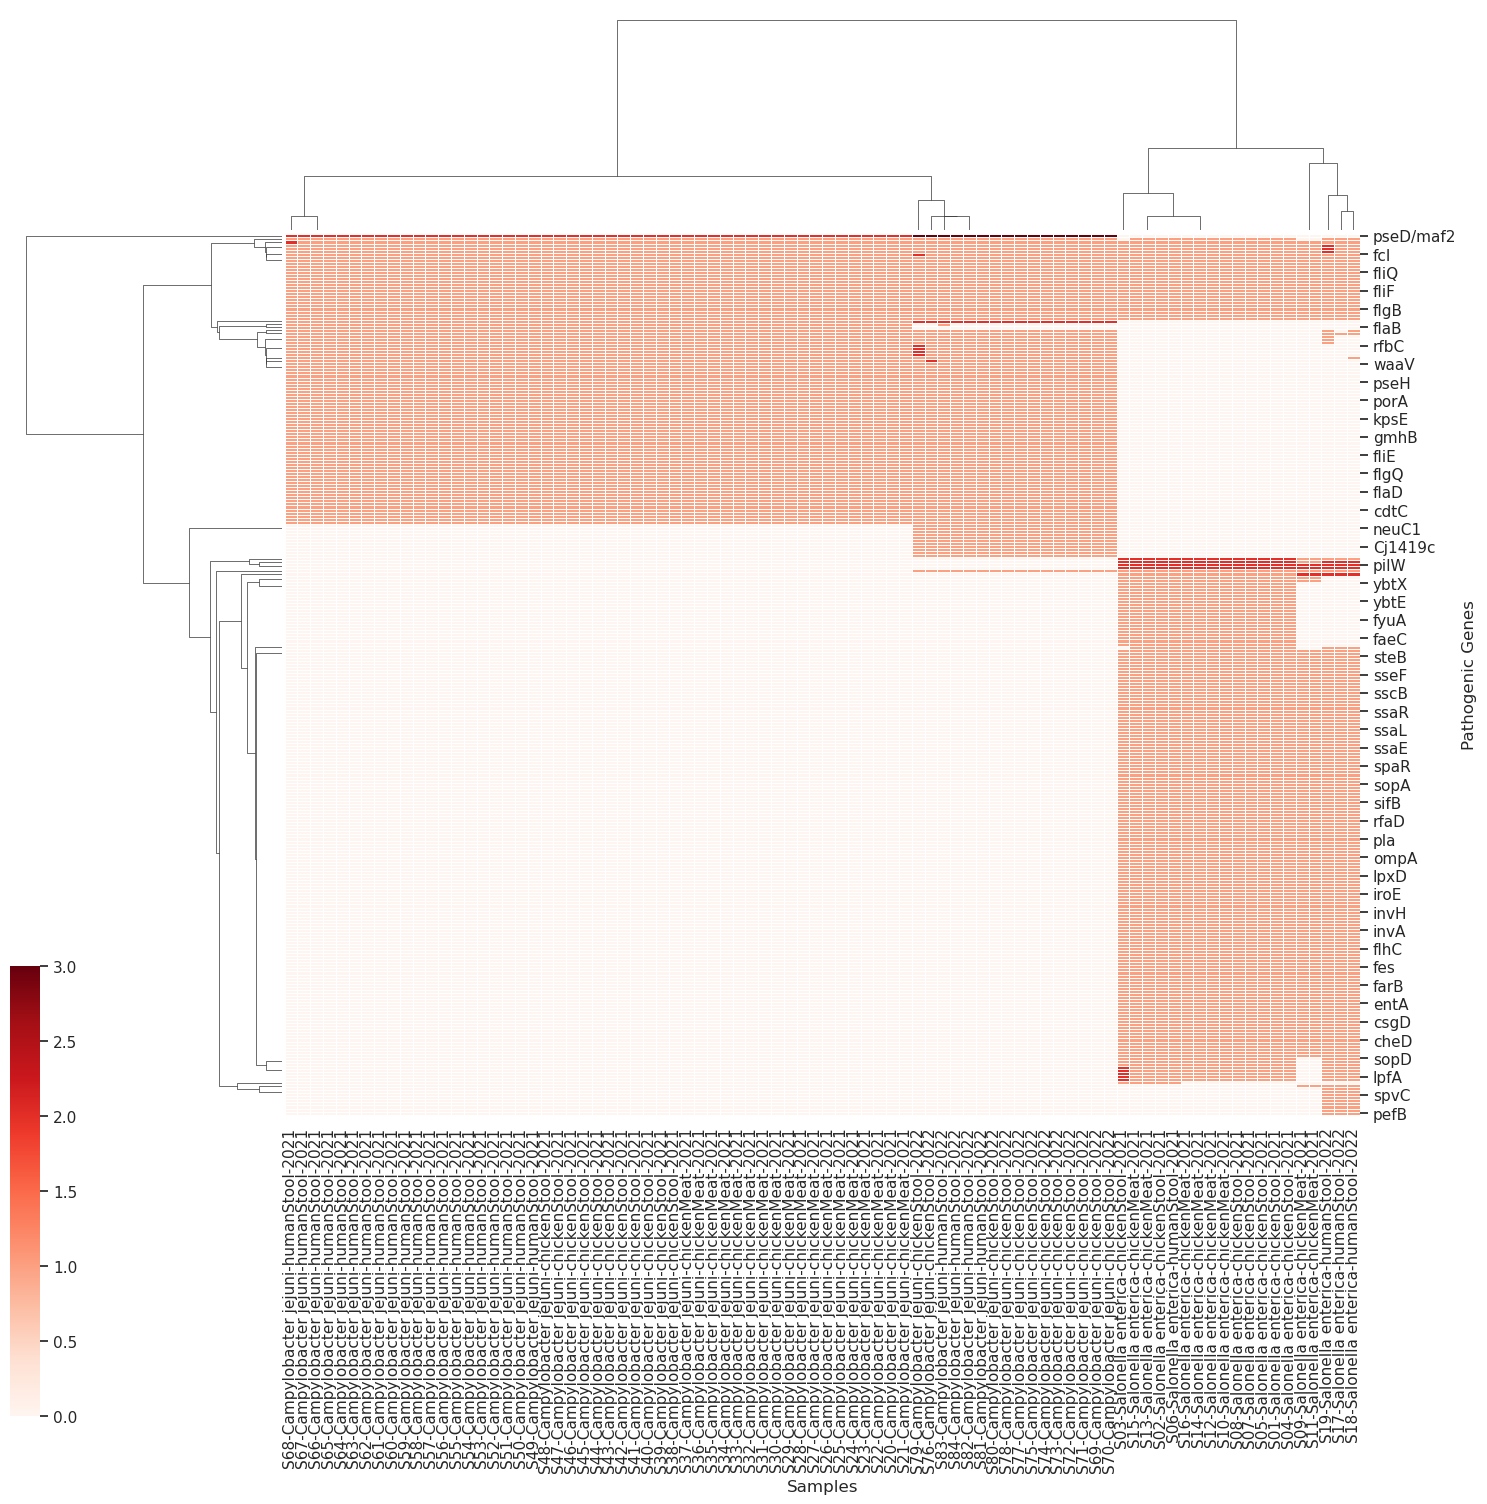

In [6]:
import scipy
heatmap_db
sns.set(font_scale=1)
g = sns.clustermap(heatmap_db, cmap="Reds", xticklabels=True, row_cluster=True, figsize=(15,15), cbar_pos=(0.01, .05, .02, .3), linewidths=0.5)
ax = g.ax_heatmap
ax.set_ylabel("Pathogenic Genes")
ax.set_xlabel("Samples")
# fig = g.get_figure()
plt.savefig(os.path.join(outpath, "clustermap_pathogenic_genes_vs_samples_palestine.svg"))
plt.savefig(os.path.join(outpath, "clustermap_pathogenic_genes_vs_samples_palestine.png"))

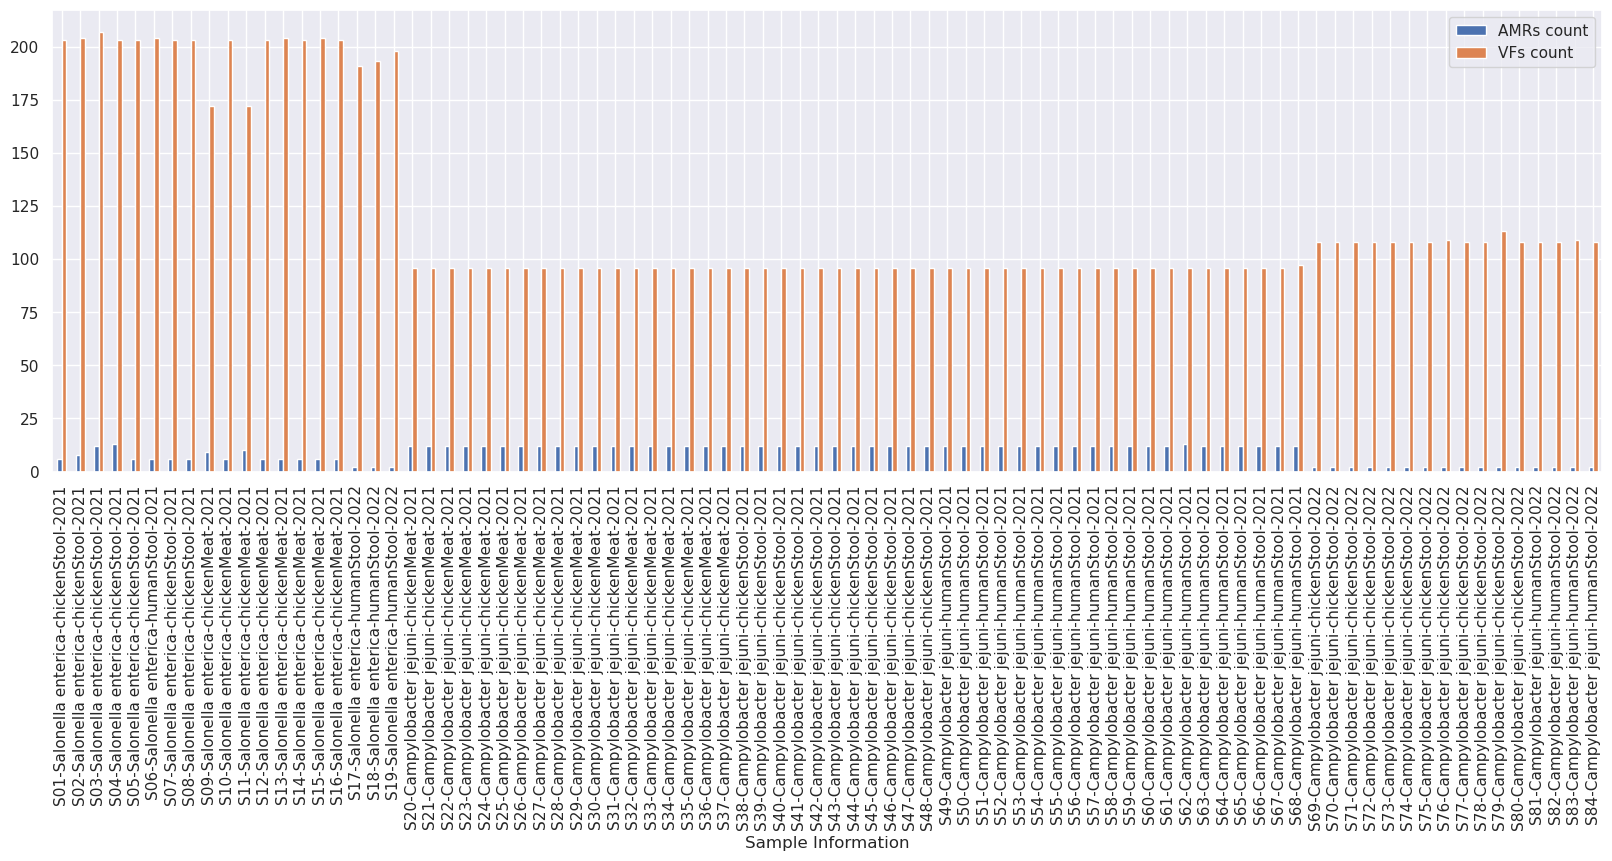

In [7]:
import matplotlib.pyplot as plt
import numpy as np

selection = result[(result["AMRs count"] != 0) | (result["VFs count"] != 0)]
selection = selection.dropna(subset = ["AMRs count","VFs count"])

selection.set_index(["Sample Information"], drop=True, inplace = True)
selection.plot( kind = "bar",
                y = ["AMRs count","VFs count"], 
                figsize=(20,6), 
                )
plt.savefig(os.path.join(outpath, "bar_plot_vfs_amrs_counts_vs_Information_palestine.svg"))
plt.savefig(os.path.join(outpath, "bar_plot_vfs_amrs_counts_vs_Information_palestine.png"))
plt.show()

/home/engynasr/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 33.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


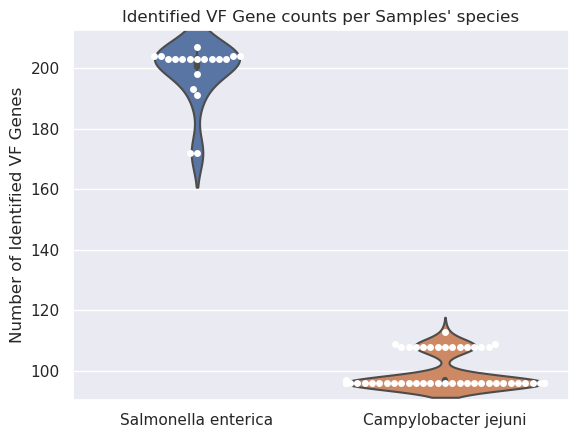

In [8]:
import seaborn as sns
ax = sns.violinplot(data=result, x="Information", y="VFs count")
sns.swarmplot(y="VFs count", x="Information", data=result, color="white", edgecolor="gray")
ax.set_title("Identified VF Gene counts per Samples' species")
ax.set_ylabel("Number of Identified VF Genes")
ax.set_xlabel("")
plt.savefig(os.path.join(outpath, "violin_plot_number_of_VFs_per_species.svg"))
plt.savefig(os.path.join(outpath, "violin_plot_number_of_VFs_per_species.png"))
plt.show()

/home/engynasr/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 32.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


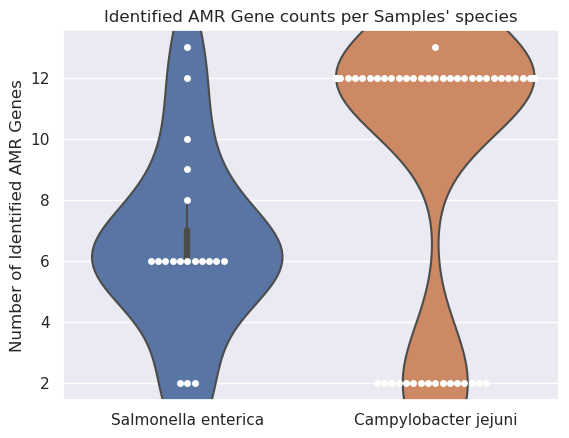

In [9]:
ax = sns.violinplot(data=result, x="Information", y="AMRs count")
sns.swarmplot(y="AMRs count", x="Information", data=result, color="white", edgecolor="gray")
ax.set_title("Identified AMR Gene counts per Samples' species")
ax.set_ylabel("Number of Identified AMR Genes")
ax.set_xlabel("")
plt.savefig(os.path.join(outpath, "violin_plot_number_of_AMRs_per_species.svg"))
plt.savefig(os.path.join(outpath, "violin_plot_number_of_AMRs_per_species.png"))
plt.show()

## Venn Diagram 

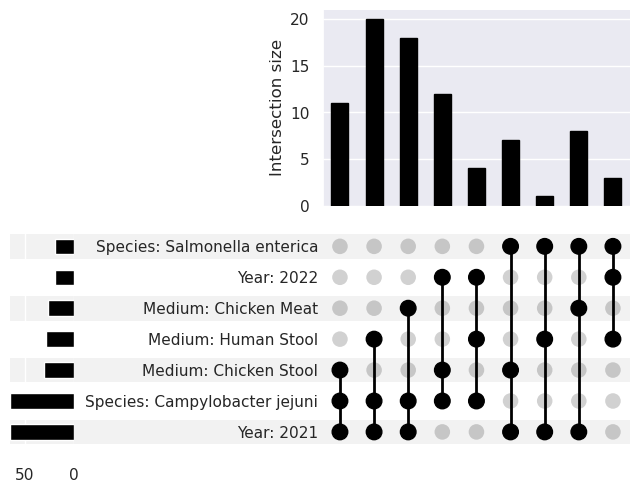

In [10]:
import upsetplot as upset

upset_db.head()


categories = list(upset_db.columns[1:len(upset_db.columns)])
palestine_metadata = upset_db[categories].astype(bool)
palestine_metadata = pd.concat([palestine_metadata,
                          upset_db[[col for col in upset_db.columns if col not in categories]]],
                         axis=1).set_index(categories)
palestine_metadata.head()


plt = upset.UpSet(palestine_metadata).plot()




In [1]:
# import widget classes and instantiate Network instance
from clustergrammer2 import Network, CGM2

net = Network(CGM2)


# load matrix file
net.load_file('galaxy_inputs/heatmap/heatmap_table_palestine_type2.csv')

# cluster using default parameters
net.cluster(enrichrgram=True)

# make interactive widget
net.widget()

>> clustergrammer2 backend version 0.18.0


CGM2(network='{"row_nodes": [{"name": "Cj1135", "ini": 289, "clust": 104, "rank": 196, "rankvar": 82}, {"name"…

In [4]:
# load matrix file
net.load_file('galaxy_inputs/heatmap/vfs_coverage_palestine_heatmap_type2.csv')

# cluster using default parameters
net.cluster(enrichrgram=True)

# make interactive widget
net.widget()

NameError: name 'net' is not defined